# Hourly PSDS - WETR & RLAS

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from functions.get_fband_average import __get_fband_average

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [14]:
config = {}


config['station1'] = "BW.RLAS..BJ"
config['station2'] = "BW.WETR..BDO"


config['d1'], config['d2'] = "2023-09-01", "2023-09-10"

config['path_to_data'] = data_path+f"LNM2/PSDS/"

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['frequency_limits'] = 1e-3, 1e1


In [4]:
# ## ---------------------------------------


# name = "FFBI_BDF"
# inname = "2023_FFBI_BDF_3600"
# subdir =  "FFBI/" ## "FFBI_absolute/"
# threshold = 8e-1
# f_limits = 1/1600, 1.0

# d1, d2 = "2023-09-23", "2023-11-30"


# ## ---------------------------------------

# path = data_path+f"LNM2/PSDS/"

# ## load configurations
# config = pickle.load(open(path+subdir+inname+"_config.pkl", 'rb'))

# config['inname'] = inname
# config['inpath'] = path+subdir
# config['f_limits'] = f_limits
# config['thres'] = threshold
# config['station'] = name

# config['outpath_figures'] = data_path+f"LNM2/figures/"

# config['frequency_limits'] = [config['f_limits'][0], config['f_limits'][1]]


In [5]:
# !ls /import/kilauea-data/LNM2/PSDS/FUR

## Methods

In [6]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [7]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [8]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [9]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    idx_min = 5

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii, idx_min:idx_max].mean() > threshold_mean:
                if ii == 0:
                    print(f" -> filter threshold between {round(ff[idx_min],4)} and {round(ff[idx_max],2)}")
                rejected.append(arr[ii, :])
                arr[ii] = ones(len(arr[ii])) * nan
                # idx_to_remove.append(ii)
        else:
            if arr[ii, :].mean() > threshold_mean:
                rejected.append(arr[ii, :])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii, :].mean() < 1e-26:
            rejected.append(arr[ii, :])
            idx_to_remove.append(ii)

    # for jj in sort(array(idx_to_remove))[::-1]:
    #     arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [10]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, names, day, show_rejected=True):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)


    ##____________________________

    NN = 5

    fig, axes = plt.subplots(NN, 1, figsize=(12, 12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24

    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)


    for j in range(NN):

        try:
            for n, psd in enumerate(psds[j]):
                axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
                p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)

            if show_rejected:
                for reject in rejected[j]:
                     axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=2)
        except:
            pass

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[j].set_xlim(1e-3, 2e0)
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)

    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)


    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .95, '(a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.01, .95, '(b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.01, .95, '(c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.01, .95, '(d)', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)
    axes[4].text(.01, .95, '(e)', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    sta, cha = names[0].split("_")[-2], names[0].split("_")[-1]
    axes[0].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)

    sta, cha = names[1].split("_")[-2], names[1].split("_")[-1]
    axes[1].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)

    sta, cha = names[2].split("_")[-2], names[2].split("_")[-1]
    axes[2].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)

    sta, cha = names[3].split("_")[-2], names[3].split("_")[-1]
    axes[3].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    sta, cha = names[4].split("_")[-2], names[4].split("_")[-1]
    axes[4].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[4].transAxes, fontsize=font)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-20, top=1e-11)
    axes[1].set_ylim(bottom=1e-20, top=1e-11)
    axes[2].set_ylim(bottom=1e-20, top=1e-11)
    axes[3].set_ylim(bottom=1e-6, top=1e4)
    axes[4].set_ylim(bottom=1e-6, top=1e5)

    axes[0].set_ylabel(r"PSD (m$^2$/s$^4$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"PSD (m$^2$/s$^4$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"PSD (m$^2$/s$^4$/Hz)", fontsize=font)
    axes[3].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)
    axes[4].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5, ticks=arange(1,N,2))


    plt.show();
    return fig

In [11]:
baro_lnm = read_csv(data_path+f"LNM2/data/"+"baro_nlnm_nhnm.csv")

baro_lnm['nlnm_baro'] = 10**(baro_lnm['nlnm_baro_db']/10)
baro_lnm['nhnm_baro'] = 10**(baro_lnm['nhnm_baro_db']/10)

## RUN for all files 

In [12]:
from functions.get_fband_averages import __get_fband_averages

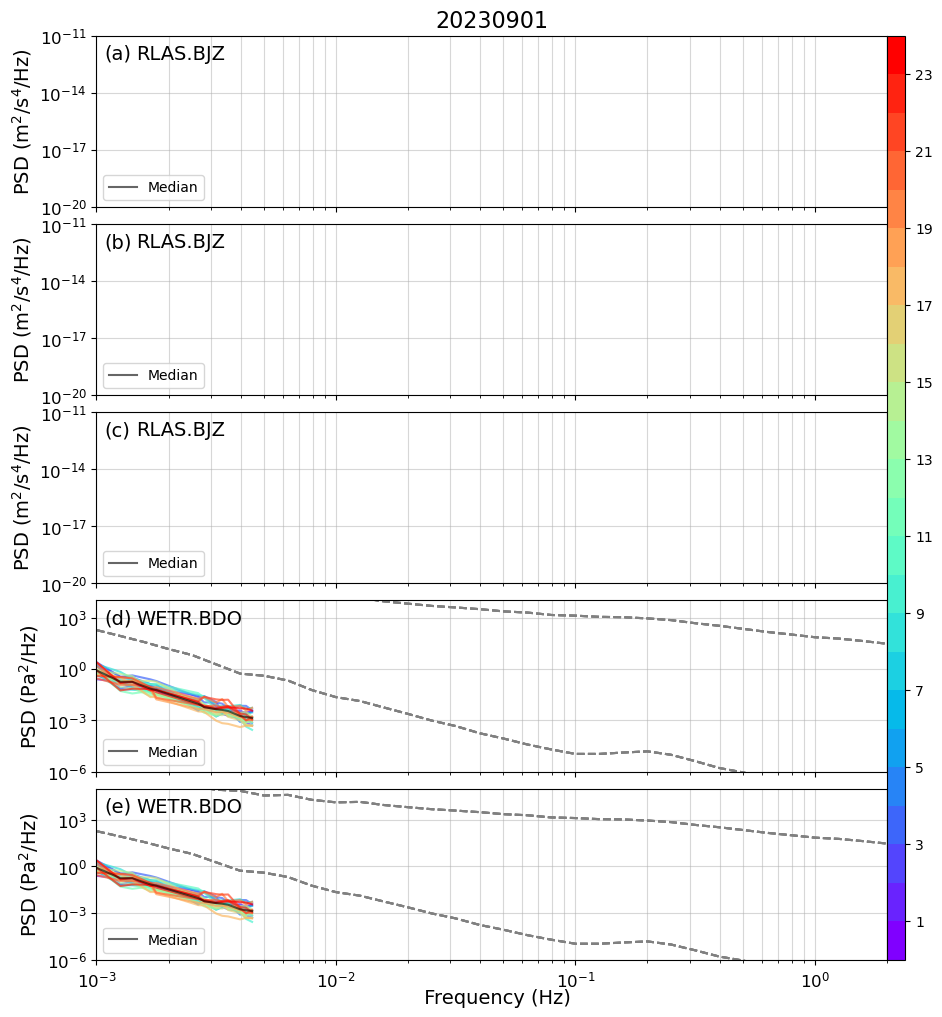

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230901.png


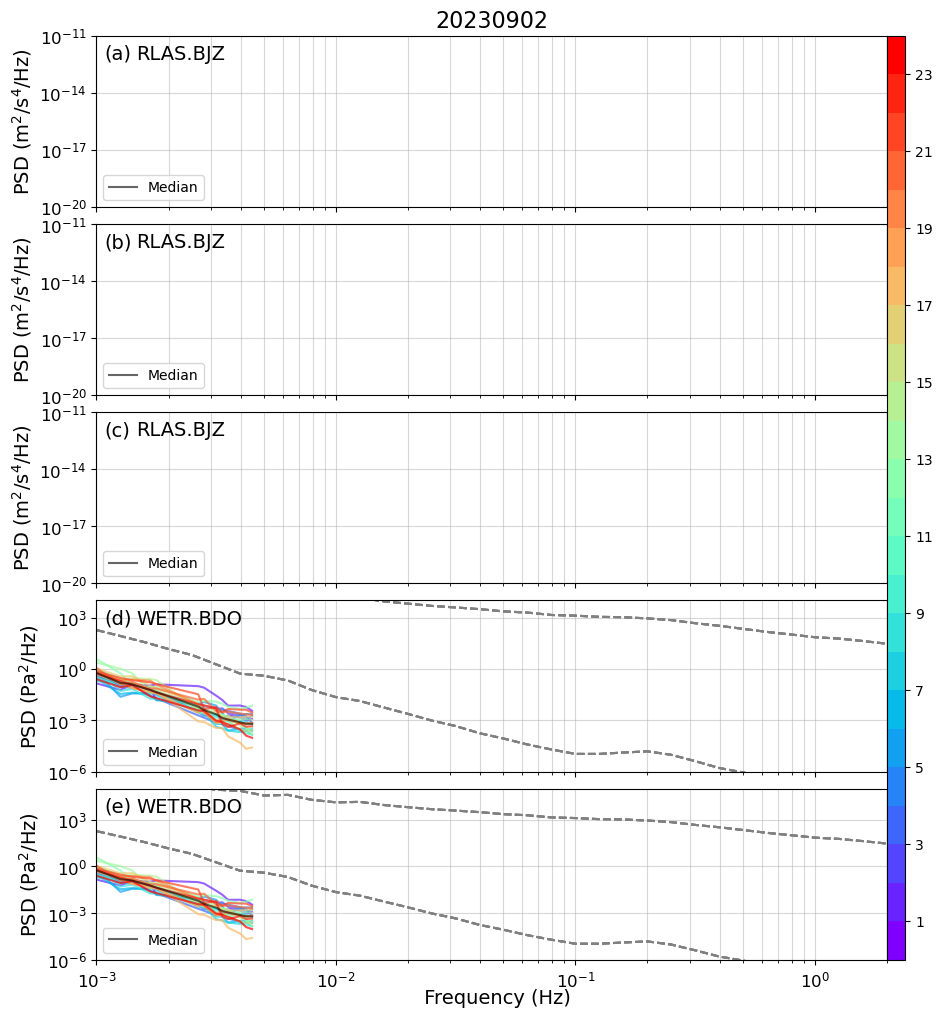

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230902.png


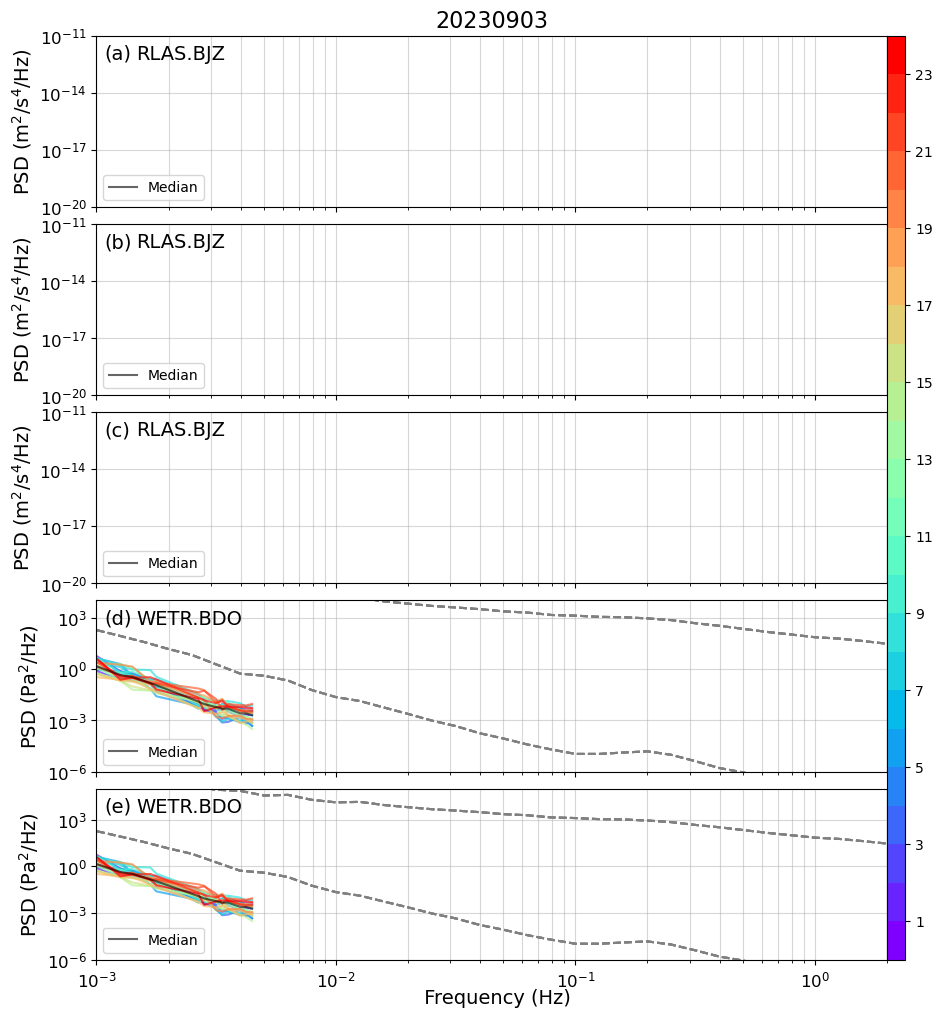

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230903.png


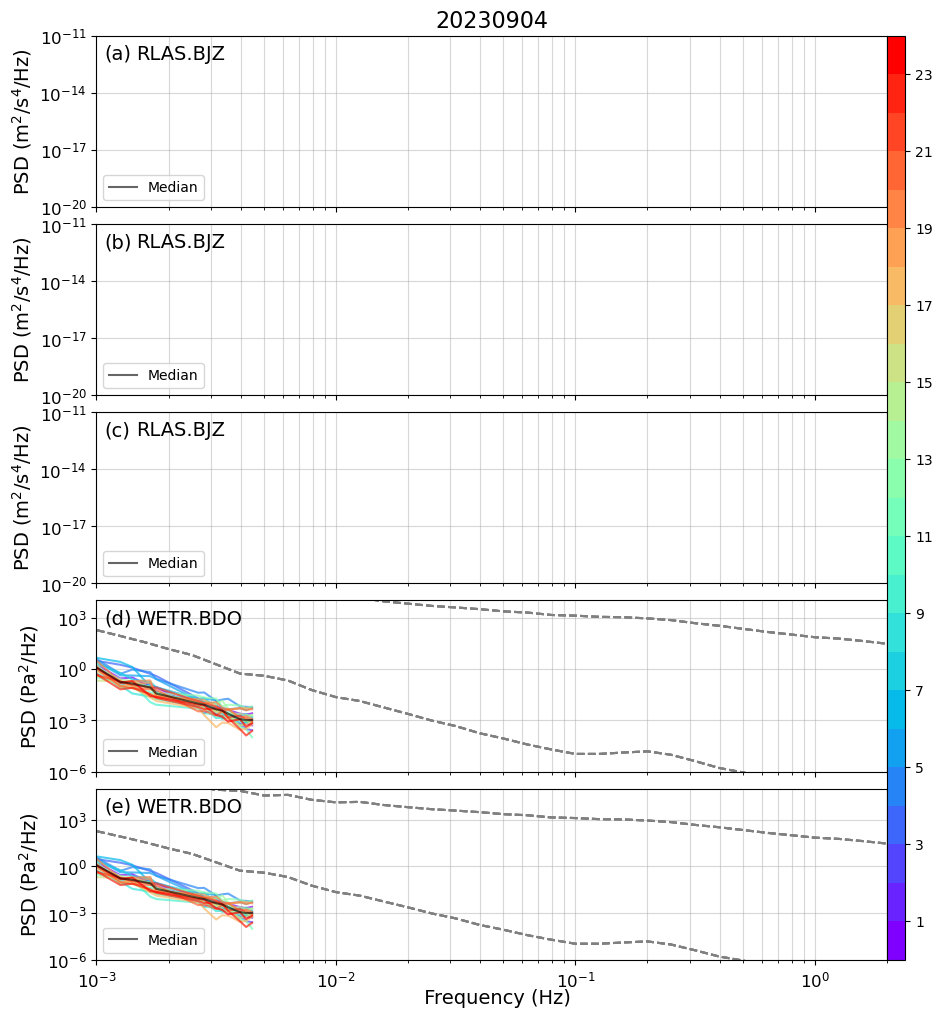

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230904.png


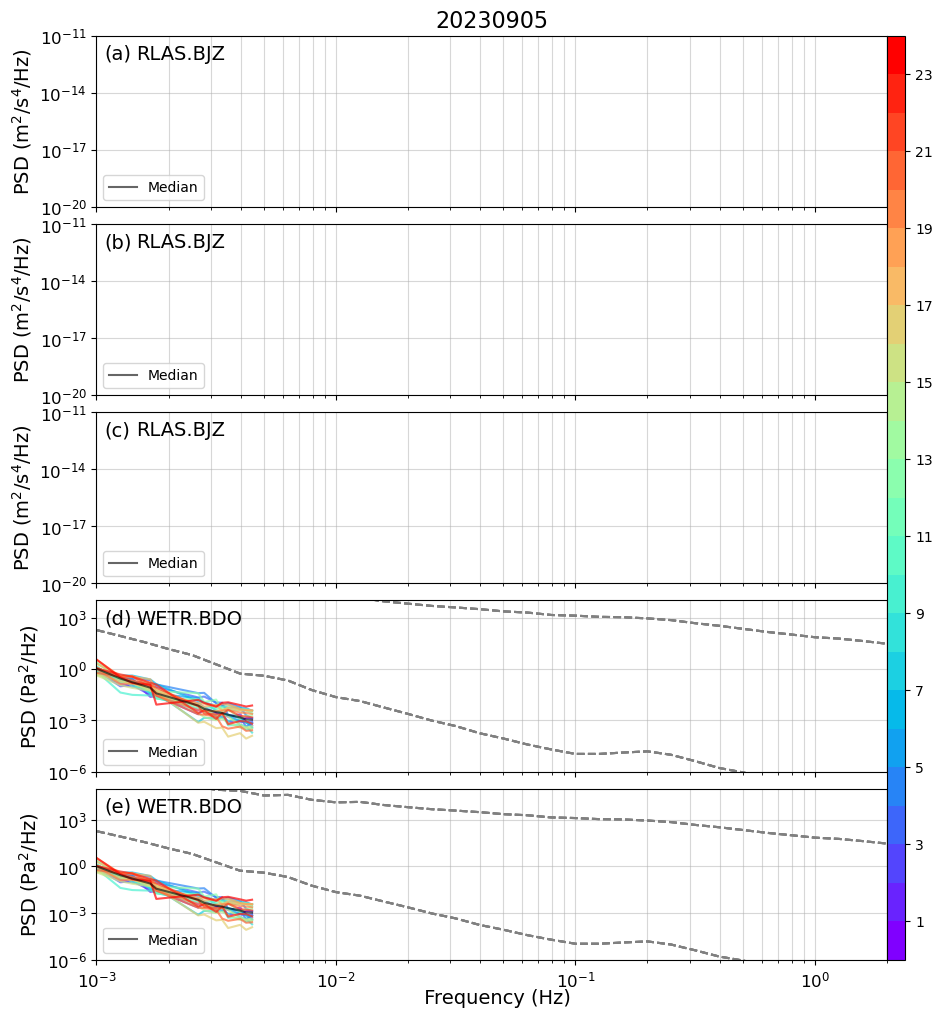

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230905.png


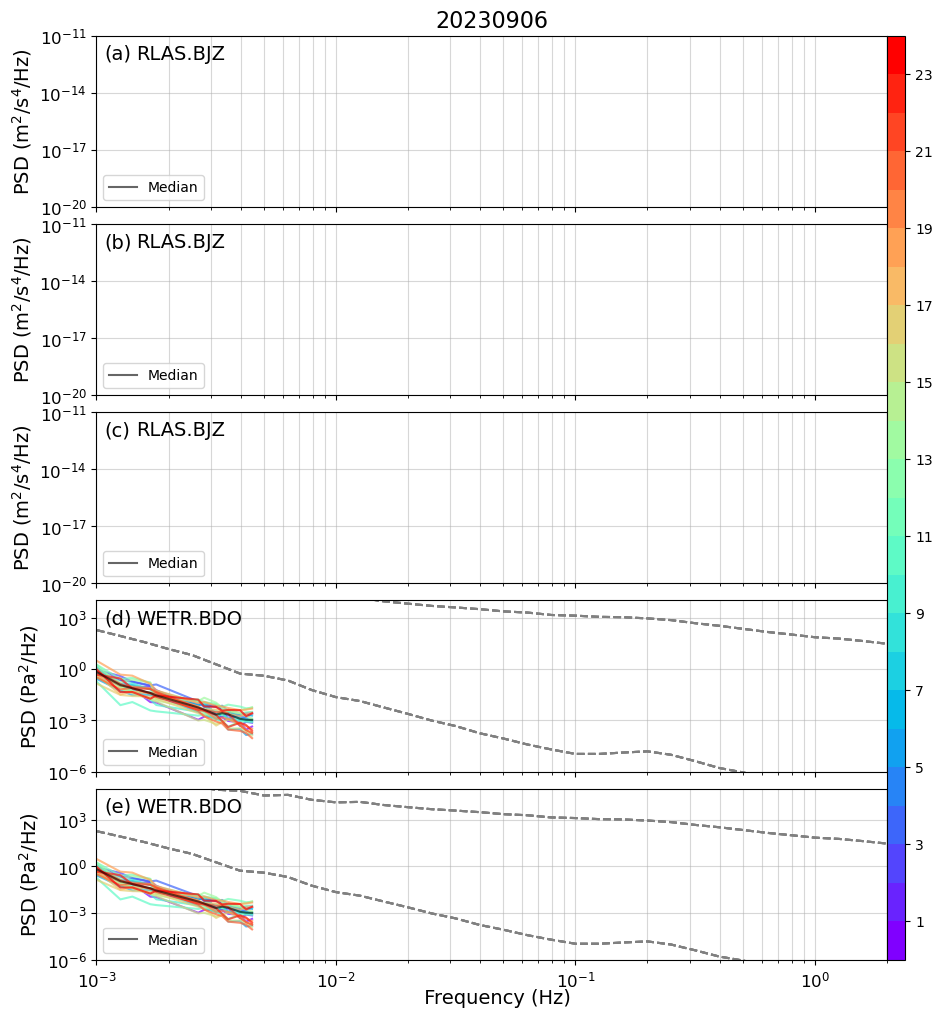

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230906.png


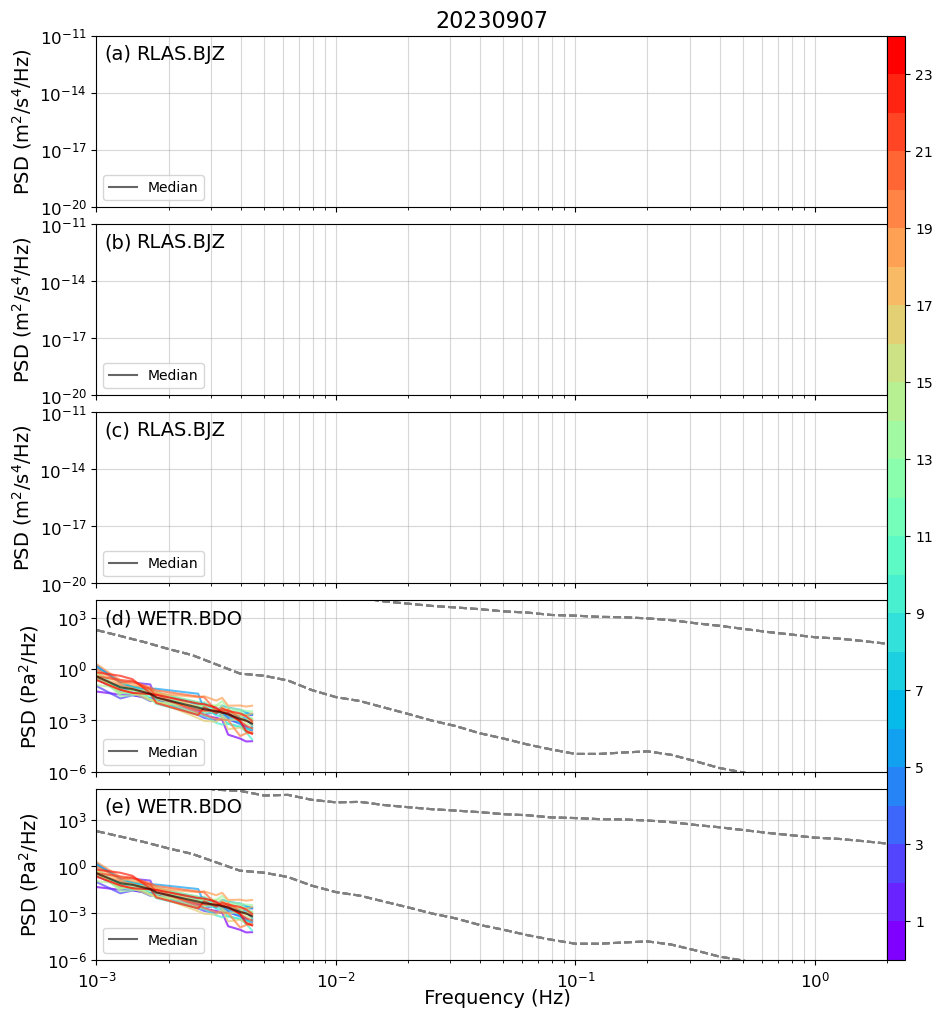

 -> saving: /home/andbro/kilauea-data/LNM2/figures/joint_20230907.png


In [ ]:

psds_medians_out, times_out = [], []

for _i, day in enumerate(date_range(config['d1'], config['d2'])):

    day = str(day).split(" ")[0].replace("-", "")

    config['outpath_figname'] = "joint_"+day

    # if _i > 1:
    #     continue

    # if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
    #     print(f" -> skipping {config['outpath_figname']} ...")
    #     continue


    try:


        ## Data1 --------------------------
        name1 = "RLAS/2023_RLAS_BJZ"

        out = read_pickle(config['path_to_data']+f"{name1}_3600_{day}_hourly.pkl")
        ff1, dat1 = out['frequencies'], out['psd']
        # dat1, rejected_dat1 = __remove_noisy_psds(dat1, threshold_mean=1e-10, ff=ff1, flim=0.05)
        # dat1, ff1 = __cut_frequencies_array(dat1, ff1, config['frequency_limits'][0], config['frequency_limits'][1])
        ff1, dat1 = __get_fband_averages(ff1, dat1)


        ## Data2 --------------------------
        name2 = "RLAS/2023_RLAS_BJZ"

        out = read_pickle(config['path_to_data']+f"{name2}_3600_{day}_hourly.pkl")
        ff2, dat2 = out['frequencies'], out['psd']

        # dat2, rejected_dat2 = __remove_noisy_psds(dat2, threshold_mean=1e-10, ff=ff2, flim=0.05)
        # dat2, ff2 = __cut_frequencies_array(dat2, ff2, config['frequency_limits'][0], config['frequency_limits'][1])
        ff2, dat2 = __get_fband_averages(ff2, dat2)


        ## Data3 --------------------------
        name3 = "RLAS/2023_RLAS_BJZ"

        out = read_pickle(config['path_to_data']+f"{name3}_3600_{day}_hourly.pkl")
        ff3, dat3 = out['frequencies'], out['psd']

        # dat3, rejected_dat3 = __remove_noisy_psds(dat3, threshold_mean=1e-10, ff=ff3, flim=0.05)
        # dat3, ff3 = __cut_frequencies_array(dat3, ff3, config['frequency_limits'][0], config['frequency_limits'][1])
        ff3, dat3 = __get_fband_averages(ff3, dat3)


        ## Data4 --------------------------
        name4 = "WETR/2023_WETR_BDO"

        out = read_pickle(config['path_to_data']+f"{name4}_3600_{day}_hourly.pkl")
        ff4, dat4 = out['frequencies'], out['psd']

        # dat4, rejected_dat4 = __remove_noisy_psds(dat4, threshold_mean=1e15, ff=ff4, flim=0.05)
        # dat4, ff4 = __cut_frequencies_array(dat4, ff4, config['frequency_limits'][0], config['frequency_limits'][1])
        ff4, dat4 = __get_fband_averages(ff4, dat4)


        ## Data5 --------------------------
        name5 = "WETR/2023_WETR_BDO"

        out = read_pickle(config['path_to_data']+f"{name5}_3600_{day}_hourly.pkl")
        ff5, dat5 = out['frequencies'], out['psd']

        # dat5, rejected_dat5 = __remove_noisy_psds(dat5, threshold_mean=1e15, ff=ff5, flim=0.05)
        # dat5, ff5 = __cut_frequencies_array(dat5, ff5, config['frequency_limits'][0], config['frequency_limits'][1])
        ff5, dat5 = __get_fband_averages(ff5, dat5)


    except Exception as e:
        print(e)
        continue

    rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5 = [], [], [], [], []

    fig = __makeplot_colorlines_overview(config,
                                         [ff1, ff2, ff3, ff4, ff5],
                                         [dat1, dat2, dat3, dat4, dat5],
                                         [rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5],
                                         [name1, name2, name3, name4, name5],
                                         day,
                                         show_rejected=True)

    print(f" -> saving: {config['outpath_figures']}{config['outpath_figname']}.png")
    fig.savefig(config['outpath_figures']+"joint_FUR/"+config['outpath_figname']+"_FUR.png", format="png", transparent=False, bbox_inches='tight', dpi=150)


In [14]:
os.system("""spd-say "Finished" """)

0

###### 